In [270]:
# This notebook is aimed to deal with the transiant state

In [271]:
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [272]:
# first,read the data and do some data analysis

In [273]:
P1T1_to_P06T1 = pd.read_csv('./transiant_data/P1T1_to_P0.6T1.csv', index_col= 0)

In [274]:
P1T1_to_P06T1.columns

Index(['keff', 'keff_relative_uncertainty', 'keff_absolute_uncertainty',
       'Cs137_0 [at/b.cm]', 'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]',
       'Cs137_3 [at/b.cm]', 'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]',
       'Cs137_6 [at/b.cm]',
       ...
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'Cs137_830 [at/b.cm]', 'Cs137_831 [at/b.cm]', 'Cs137_832 [at/b.cm]',
       'Cs137_833 [at/b.cm]'],
      dtype='object', length=837)

In [275]:
def process(df):
    # read in a pandas frame, remove the keff_relative_uncertainty and keff_absolute_uncertainty
    # return the keff and the data columns

    df = df.drop('keff_relative_uncertainty',axis = 1)
    df = df.drop('keff_absolute_uncertainty', axis = 1)

    keff = df.pop('keff')

    # print(type(df))

    return keff, df

In [276]:
keff, data = process(P1T1_to_P06T1)

data.columns


Index(['Cs137_0 [at/b.cm]', 'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]',
       'Cs137_3 [at/b.cm]', 'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]',
       'Cs137_6 [at/b.cm]', 'Cs137_7 [at/b.cm]', 'Cs137_8 [at/b.cm]',
       'Cs137_9 [at/b.cm]',
       ...
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'Cs137_830 [at/b.cm]', 'Cs137_831 [at/b.cm]', 'Cs137_832 [at/b.cm]',
       'Cs137_833 [at/b.cm]'],
      dtype='object', length=834)

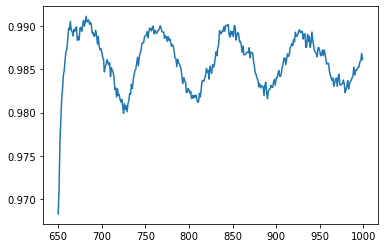

In [277]:
plt.plot(keff)

In [278]:
def generate_histogram(data: np.ndarray, binInt = 1.0e-06, binMax = 1.5e-04):
    '''
    Take in a data with columns are features  Transform the features with histogram method
    '''

    # Extract data
    Xvals = data

    nRows, nCols = Xvals.shape

    # define bins
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1


    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    return nCountsX

In [279]:
hist_data = generate_histogram(data.to_numpy())

In [280]:
data.iloc[0,:]

Cs137_0 [at/b.cm]     NaN
Cs137_1 [at/b.cm]     NaN
Cs137_2 [at/b.cm]     NaN
Cs137_3 [at/b.cm]     NaN
Cs137_4 [at/b.cm]     NaN
                       ..
Cs137_829 [at/b.cm]   NaN
Cs137_830 [at/b.cm]   NaN
Cs137_831 [at/b.cm]   NaN
Cs137_832 [at/b.cm]   NaN
Cs137_833 [at/b.cm]   NaN
Name: 650, Length: 834, dtype: float64

In [281]:
hist_data[0] # this is super wired, all cs in first row is nan

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [282]:
# align the data such that each row is a keff and the cesian concetration from last step

# delete the fist element in keff

keff = keff.to_numpy()
keff = keff[1:]
print(keff.shape)

# delete the last row in hist_data

hist_data = hist_data[:-1]
print(hist_data.shape)

(349,)
(349, 150)


In [283]:
'''
a reminder, shoule we remove the first column since all cs is 0?
'''

'\na reminder, shoule we remove the first column since all cs is 0?\n'

In [284]:
# Then, we concentrate keff and data together

all_data = np.append(hist_data, keff.reshape(-1,1), axis=1)
all_data.shape

(349, 151)

In [285]:
# cut the data length so it can fit time sequence length, which is 10

sequence_length = 10

all_data = all_data[: len(all_data)//sequence_length * sequence_length]

In [286]:
# add power and threshold

def add_one_column (arr,new_col_value):
    # Create a new column of single value to add to the front of the array
    new_col = np.full((arr.shape[0]), new_col_value)

    # Use insert to insert the new column to the front of the array
    new_arr = np.insert(arr, 0, new_col, axis=1)

    return new_arr

def add_Power_and_Threshold(arr, p = 1, t = 1):
    arr = add_one_column(arr, p)
    arr = add_one_column(arr, t)

    return arr

all_data = add_Power_and_Threshold(all_data, 0.6, 1)





In [287]:
# combine all the above step

def get_data(filename, p =1, t = 1):
    df = pd.read_csv(filename, index_col= 0)

    keff, data = process(df)
    hist_data = generate_histogram(data.to_numpy())

    # delete the fist element in keff

    keff = keff.to_numpy()
    keff = keff[1:]
    # print(keff.shape)

    # delete the last row in hist_data

    hist_data = hist_data[:-1]
    # print(hist_data.shape)

    all_data = np.append(hist_data, keff.reshape(-1,1), axis=1)

    all_data = all_data[: len(all_data)//sequence_length * sequence_length]

    all_data = add_Power_and_Threshold(all_data, p ,t)

    return all_data
    


In [288]:
# lets get the data

P1T1_to_P06T1 = get_data('./transiant_data/P1T1_to_P0.6T1.csv',0.6,1)

P1T1_to_P08T1 = get_data('./transiant_data/P1T1_to_P0.8T1.csv',0.8,1)

P1T1_to_P1T11 = get_data('./transiant_data/P1T1_to_P1T1.1.csv',1,1.1)

P1T1_to_P1T09 = get_data('./transiant_data/P1T1_to_P1T0.9.csv',1,0.9)




In [289]:
P1T1_to_P06T1.shape

(340, 153)

In [290]:
# concentrate all data together and do the standarlize
add_order = [P1T1_to_P06T1,P1T1_to_P08T1,P1T1_to_P1T11,P1T1_to_P1T09]
all_data = np.concatenate(add_order, axis=0)
all_data.shape

(1360, 153)

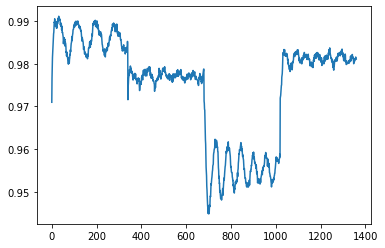

In [291]:
plt.plot(all_data[:,-1])

In [292]:
data = all_data

ss = StandardScaler()

data = ss.fit_transform(data)


clean_data = data.copy()

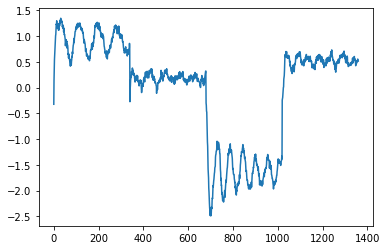

In [293]:
plt.plot(data[:,-1])

In [294]:
# define the training and testing set
training_data = ReactorData(data,10,0,0.75)


testing_data = ReactorData(data,10,0.75,1)

training_and_testing_data = ReactorData(data,10,0,1)

In [295]:
# define neural nets

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 64,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}


model = SimpleLSTM(**nets_hyper_parameters)

In [296]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.01,
    'weight_decay' : 0.01
}

train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 200,
    'batch_size':16,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20

}


model, _ = train(** train_parameters)

The loss is 3.3907354761589015 in epoch 0
The loss is 0.22576352185087728 in epoch 20
The loss is 0.17392080600096 in epoch 40
The loss is 0.15484742534917104 in epoch 60
The loss is 0.10101497955930692 in epoch 80
The loss is 0.08692113336561351 in epoch 100
The loss is 0.18062142577063114 in epoch 120
The loss is 0.12258034228849177 in epoch 140
The loss is 0.13568107963209328 in epoch 160
The loss is 0.1060716419549685 in epoch 180
Training is finished, the final loss is 0.16636730933471253


In [297]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def eval(data):
    # Assuming you have a DataSet object called 'training_data' and a trained model called 'model'
    training_set = data
    # Step 1: Create a DataLoader from your DataSet object
    batch_size = 16  # Adjust this value based on your model's input requirements
    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

    # Step 2 & 3: Iterate through the DataLoader and collect predictions and true labels
    predictions = []
    true_labels = []

    sequence_length = 10  # Assuming a sequence length of 10

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in train_loader:
            # Pass the input data to the trained model and collect the predictions
            preds = model(inputs)
            preds = preds.reshape(-1, sequence_length)  # Reshape the predictions to (batch_size, sequence_length, output_dim)
            predictions.extend(preds.squeeze().view(-1).tolist())  # Flatten the predictions
            true_labels.extend(labels.squeeze().view(-1).tolist())  # Flatten the true labels

    # Step 4: Plot the predictions and true labels for comparison
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Keff')
    plt.plot(true_labels, label="Real")
    plt.plot(predictions, label="Predict")
    plt.legend()
    plt.show()

    return np.array(true_labels), np.array(predictions)


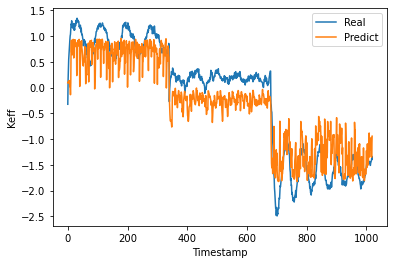

In [298]:
training_label, training_pred =  eval(training_data)

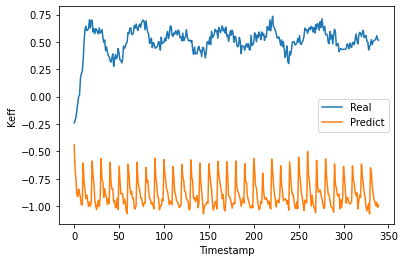

In [299]:
testing_label, testing_pred =  eval(testing_data)

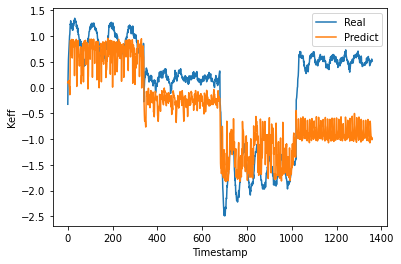

In [300]:
all_label, all_pred =  eval(training_and_testing_data)

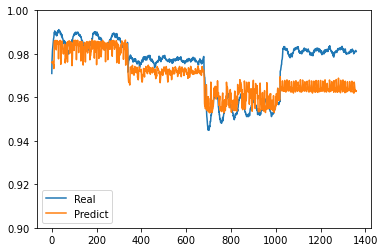

In [304]:
# change to the original unit
true_labels = all_label
predictions = all_pred
X = training_and_testing_data.unshaped_data

result_y = np.append(X, true_labels.reshape(-1,1), axis=1)
result_predict = np.append(X, predictions.reshape(-1,1), axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.9,1))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict")
plt.legend()


In [ ]:
'''
some points

should add some stable data?
should increse model size?
should do some more data prepocessing?
should use pre-trained model?
'''